In [1]:
import sys
sys.path.insert(1, '/home/taylor/Classes/cs230/achtung')
import achtung_process;

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import gym
import numpy as np
import pickle
import torch as th
import torch.nn as nn

In [4]:
from stable_baselines3 import A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.vec_env import VecTransposeImage
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

In [5]:
env = achtung_process.AchtungProcess(1)
env.env.speed = 0 # set to zero for training (i.e., no frame delay)
env.env.render_game = False

Achtung Die Kurve!


In [6]:
class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 128):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)

In [7]:
model = A2C("CnnPolicy", 
            DummyVecEnv([lambda: env]), 
            policy_kwargs=policy_kwargs,
            ent_coef=0.01,
            vf_coef=0.25)

In [8]:
# Evaluate the initial random policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:60.50 +/- 28.20


In [9]:
# Train
rewards = []
stds = []
for i in range(100):
    print("iteration: ", i+1)
    model.learn(total_timesteps=10000)
    print("   saving...")
    model.save("a2c_achtung")
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
    print(f"   mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
    
    rewards.append(mean_reward)
    stds.append(std_reward)
    
    with open("baselines_training/a2c_reward.txt", "wb") as f:   
        pickle.dump(rewards, f)
    with open("baselines_training/a2c_std.txt", "wb") as f:   
        pickle.dump(stds, f)

iteration:  1
   saving...
   mean_reward:51.58 +/- 19.43
iteration:  2
   saving...
   mean_reward:45.51 +/- 7.51
iteration:  3
   saving...
   mean_reward:38.45 +/- 5.10
iteration:  4
   saving...
   mean_reward:54.01 +/- 21.02
iteration:  5
   saving...
   mean_reward:38.47 +/- 4.58
iteration:  6
   saving...
   mean_reward:37.85 +/- 4.31
iteration:  7
   saving...
   mean_reward:38.21 +/- 4.67
iteration:  8
   saving...
   mean_reward:37.97 +/- 5.39
iteration:  9
   saving...
   mean_reward:38.00 +/- 5.10
iteration:  10
   saving...
   mean_reward:38.42 +/- 4.81
iteration:  11
   saving...
   mean_reward:37.97 +/- 4.42
iteration:  12
   saving...
   mean_reward:43.79 +/- 14.82
iteration:  13
   saving...
   mean_reward:50.81 +/- 20.58
iteration:  14
   saving...
   mean_reward:47.21 +/- 14.08
iteration:  15
   saving...
   mean_reward:39.19 +/- 7.59
iteration:  16
   saving...
   mean_reward:53.76 +/- 17.29
iteration:  17
   saving...
   mean_reward:38.38 +/- 4.43
iteration:  18
  

KeyboardInterrupt: 

In [11]:
# Evaluate the trained policy
model.load("a2c_achtung")
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:51.71 +/- 16.07


Text(0.5, 1.0, 'advantage actor critic')

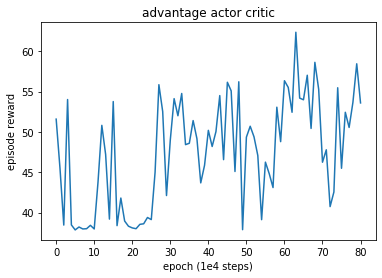

In [12]:
plt.plot(rewards)
plt.xlabel('epoch (1e4 steps)')
plt.ylabel('episode reward')
plt.title('advantage actor critic')